let's try the following configuration:
40k pictures, 64 x 64 resolution, 10 FPS, 5 seconds.

In [1]:
import torch
import time
import pylab
#from phi.flow import *
from phi.torch.flow import *

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.7.1+cu118
11.8
True
NVIDIA GeForce RTX 3060


In [3]:
backend.default_backend().list_devices('GPU')

[torch device 'NVIDIA GeForce RTX 3060' (GPU 'cuda:0') | 12287 MB | 28 processors | compute capability 8.6]

In [4]:
nx, ny = 64, 64
batch_size = 250

In [5]:
density = CenteredGrid(
    math.where(math.random_uniform(batch(dim1 = batch_size), spatial(x=64, y=64)) > 0.7, 1.0, 0.0),
    extrapolation.BOUNDARY,
    bounds=Box(x=(0, 64), y=(0, 64))
)

diffusion_rate = 0.1

for _ in range(10):
    density = field.laplace(density) * diffusion_rate + density

smoke = density

In [6]:
DT = 1
NU = 0.03
NUM_STEPS = int(40 / DT)
num_cols = 5

In [7]:
velocity = StaggeredGrid(
    math.zeros(batch(dim1 = batch_size), spatial(x=64, y=64), channel(vector='x,y')),
    extrapolation=extrapolation.BOUNDARY,
    bounds=Box(x=nx, y=ny)
)

In [8]:
velocity

Field[(xˢ=63, yˢ=63, dim1ᵇ=250, vectorᶜ=x,y)]

In [9]:
smoke

Field[(dim1ᵇ=250, xˢ=64, yˢ=64)]

C:\Python\envs\phiflow\lib\site-packages\phiml\backend\torch\_torch_backend.py:873: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(row_pointers, column_indices, values, shape, device=values.device)


1.4475111961364746
Max. velocity and mean marker density: [(dim1ᵇ=250) 0.282 ± 0.028 (2e-01...4e-01), (dim1ᵇ=250) 0.300 ± 0.007 (3e-01...3e-01)]


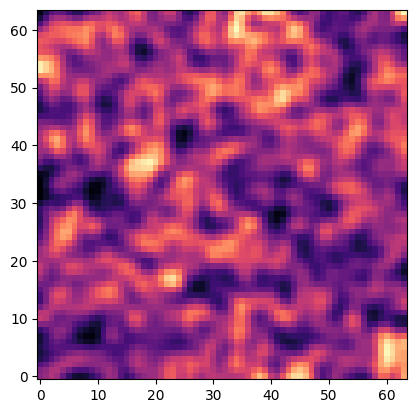

In [10]:
def step(velocity, smoke, pressure, dt=1.0, buoyancy_factor=0.5):
    smoke = advect.semi_lagrangian(smoke, velocity, dt)
    buoyancy_force = (smoke * (0, buoyancy_factor)).at(velocity)  # resamples smoke to velocity sample points
    velocity = advect.semi_lagrangian(velocity, velocity, dt) + dt * buoyancy_force
    velocity = diffuse.explicit(velocity, NU, dt)
    velocity, pressure = fluid.make_incompressible(velocity, (), Solve('auto', 1e-3))
    return velocity, smoke, pressure
start = time.time()
velocity, smoke, pressure = step(velocity, smoke, None, dt=DT)
print(time.time() - start)
print("Max. velocity and mean marker density: " + format( [ math.max(velocity.values) , math.mean(smoke.values) ] ))

smoke_0 = smoke[{'dim1': 0}]     # первый батч

pylab.imshow(np.asarray(smoke_0.values.numpy('y,x')), origin='lower', cmap='magma')

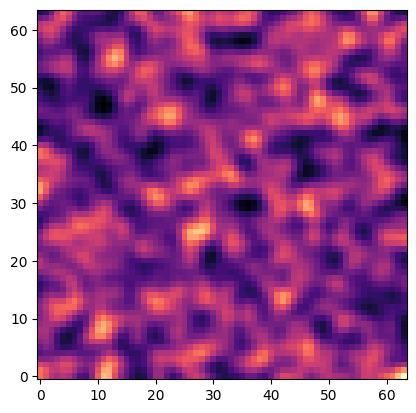

In [11]:
smoke_0 = smoke[{'dim1': 1}]     # первый батч

pylab.imshow(np.asarray(smoke_0.values.numpy('y,x')), origin='lower', cmap='magma')

In [12]:
#steps = [[ smoke.values, velocity.vector['x'], velocity.vector['y'] ]]
steps = [[ smoke, velocity ]]
start = time.time()
for time_step in range(NUM_STEPS):
    if time_step<3 or time_step%10==0:
        print('Computing time step %d' % time_step)
    velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
    #if time_step%5==0:
    steps.append( [smoke, velocity] )
print(time.time() - start)

Computing time step 0
Computing time step 1
Computing time step 2
Computing time step 10
Computing time step 20
Computing time step 30
25.856079816818237


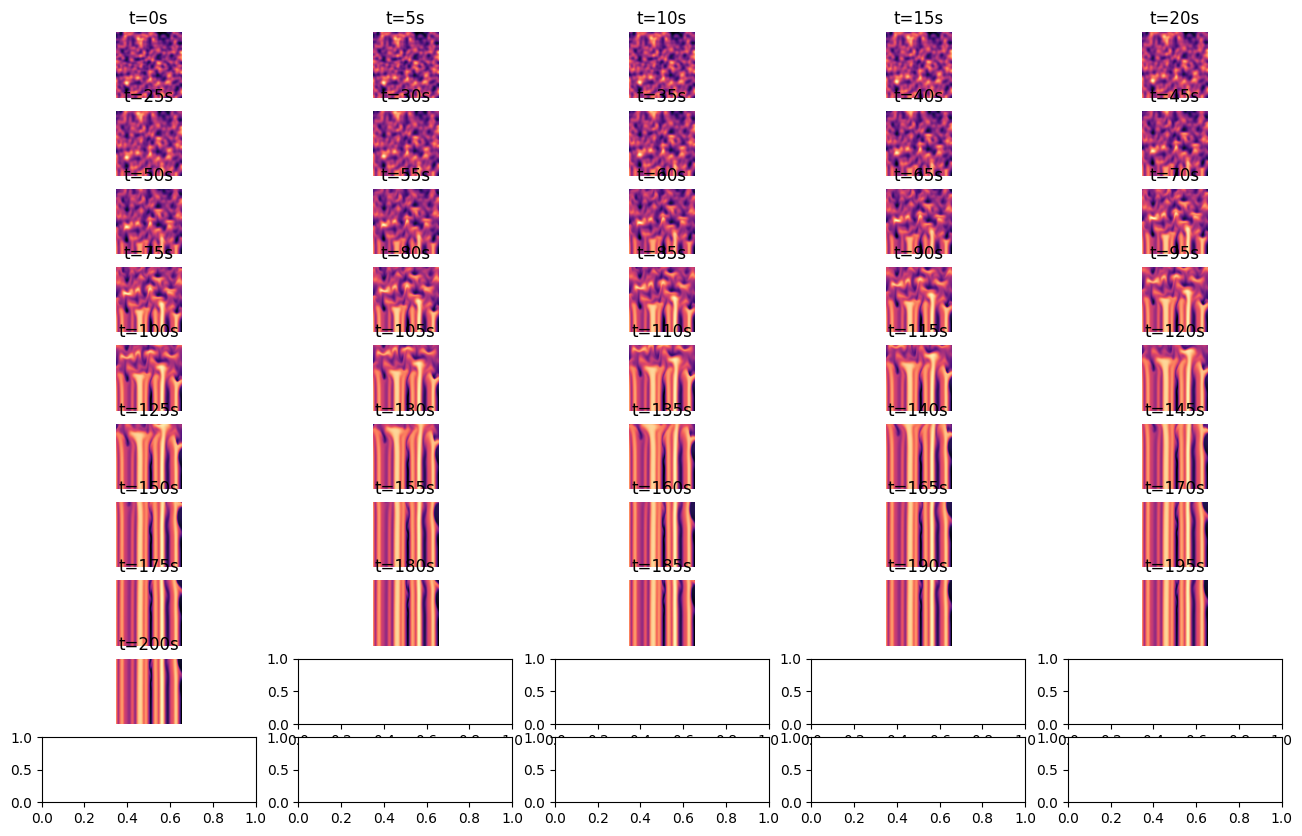

In [13]:
fig, axes = pylab.subplots(10, num_cols, figsize=(16, 10))  # 2 строки, больше высота
for i in range(len(steps)):
    row = i // num_cols  
    col = i % num_cols   
    axes[row, col].imshow(steps[i][0].values[{'dim1': 5}].numpy('y,x'), origin='lower', cmap='magma')
    axes[row, col].set_title(f"t={i*5}s")
    axes[row, col].axis('off')  

In [14]:
steps = steps[:-1:]

In [19]:
stew

40

In [16]:
grid_size = (64, 64)       # текущий шаг или время
T_total = 40   # общее время
  # скалярное нормированное время
#tau_matrix = np.full((batch_size, *grid_size), fill_value=tau)

In [17]:
tau_matrix.shape

NameError: name 'tau_matrix' is not defined

In [20]:
import numpy as np

def collect_dataset(steps):
    dataset = None
    np_smoke = steps[0][0].numpy('dim1,x,y')
    counter = 1
    for smoke, velocity in steps:
        vel_centered = velocity.at(smoke)
        vel_x_np = vel_centered.vector['x'].numpy('dim1,x,y')
        vel_y_np = vel_centered.vector['y'].numpy('dim1,x,y')
        tau = counter / T_total
        tau_matrix = np.full((batch_size, *grid_size), fill_value=tau)
        batch = np.stack([np_smoke, vel_x_np, vel_y_np, tau_matrix], axis=1) 
        counter += 1
        if dataset is None: dataset = batch
        else: dataset = np.concatenate([dataset, batch], axis=0)  
    return dataset

In [21]:
dataset = collect_dataset(steps)

In [22]:
dataset.shape

(10000, 4, 64, 64)

In [23]:
np.save('D://smoke_dataset//test_dataset.npy', dataset)

In [ ]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generate(
            num_images=self.num_img,
            diffusion_steps=PLOT_DIFFUSION_STEPS,
        ).numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


image_generator_callback = ImageGenerator(num_img=10)

ddm.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)